# **ORB Feature Matcher**

### 🔍 What is ORB?

- ORB (Oriented FAST and Rotated BRIEF) is a lightweight, real-time feature detection method. It’s optimized for speed and low memory usage—perfect for filtering images fast (and it has no license restriction issues). 

### 🤔 Why do we need ORB?

- When you're uploading input images, it's easy to accidentally toss in an unrelated one, which can mess up your mesh. No worries, because ORB has your back! It compares key visual features and filters out the odd ones, keeping your input clean.

### ⚙️ How does ORB work?

- Even if your photos have different angles, lighting, or cameras, they still capture the same object. ORB identifies consistent visual patterns between them, and matches the real-world structure, not just pixels. That way, it removes noisy or mismatched images before generating your 3D mesh. :)

**P.S.** If you want to dive deeper into how ORB works and how stacks up against other methods like SIFT and SURF? Check out this article: [A Comparison of SIFT, SURF, and ORB on OpenCV](https://mikhail-kennerley.medium.com/a-comparison-of-sift-surf-and-orb-on-opencv-59119b9ec3d0)

### Time to put it to the test!

> Let's check our images.

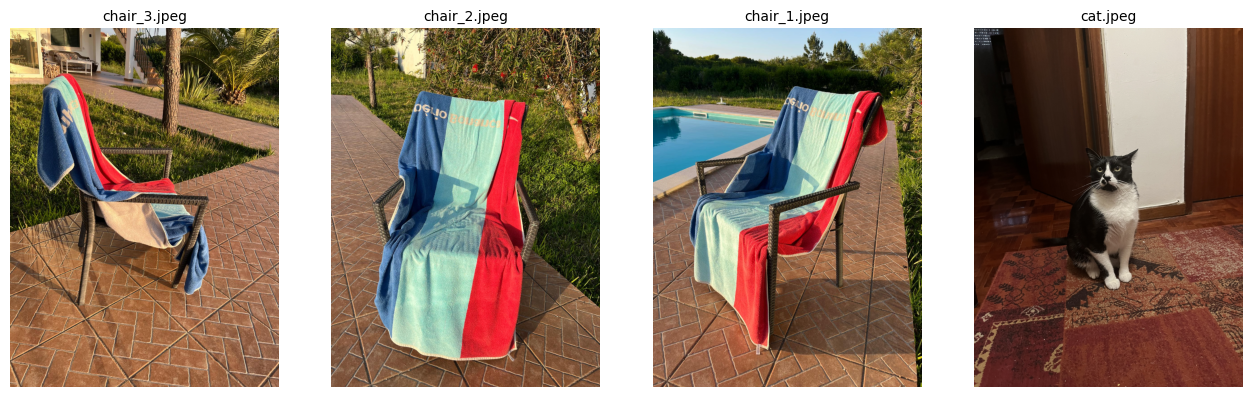

In [ ]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Path to the images
image_dir = '../test_images'
image_files = sorted(
    [f for f in os.listdir(image_dir) if f.endswith('.jpeg')],
    reverse=True
)

# Read the images
images = []
for file in image_files:
    path = os.path.join(image_dir, file)
    img = cv.imread(path)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB for matplotlib
    images.append((file, img_rgb))  # Save filename and image

# Plot the images
fig, axs = plt.subplots(1, len(images), figsize=(13, 4))
for ax, (filename, img) in zip(axs, images):
    ax.imshow(img)
    ax.set_title(filename, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()


> I’ve got 3 images of a chair with a towel that I want to mesh for my game, but when I was feeding them into the program, I accidentally tossed in a photo of my cat... Let’s see how ORB reacts.